### Frederic Chemali ASI 2A - Image processing course
# Multi-channels level control using hand gestures

#### Control the height of 5 different bars using only hand gestures. First recognise the number shaped with the fingers of the left hand, then adjust the level of this specific channel using gestures from the right hand.

The first step in this project will be to isolate the hand and determine the number shown with it. To accomplish this we will first apply pure computer vision methodes and then compare them with more advanced deep learning methods to see which one gives the best result.

We will then procceed with the channels control using hand gesture with the best methode.

In [1]:
# !pip install mediapipe --user
# !pip install ipywidgets
# !pip install scikit-image
# !pip install keras

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
from os import listdir
from os.path import isfile, join
from CVhandDetectionModule import createMask, DetectAndCropImage, f, g, load_YOLO_model, DPhandDetection, BGsubstract, WaterShedStatic,WaterShed2

global img,contours
onlyfiles = ['./FingerImages/'+f for f in listdir('./FingerImages') if isfile(join('./FingerImages/', f))]

Loading BokehJS ...

### Now that we imported everything we need, we can start our processing.
## Hand detection using HSV mask
#### We will first try to isolate the hand using only computer vision techniques, the HSV mask range
The first and most basic isolation methode we will use will be selecting a specific color range in the HSV color space and pick it to create a mask which will be used to crop the hand out of the background. We choose HSV color space because we want to separate color components from intensity for various reasons, such as robustness to lighting changes, or removing shadows. (We could have picked YCbCr, Lab, etc,)
An image can be picked using the dropdown widget, and the HSV mask parameters can be changed using the sliders.
Because we are using only computer vision, the parameters should be modified for every image, so this isolation task isn't autonomous, and that's a big drawback. The default paramters are optimised for '00palm' so it's recommended to experiment with it.

In [5]:
interact(f, img_path=onlyfiles,
         Hmin=widgets.IntSlider(min=0, max=255, step=1, value=1),
         Hmax=widgets.IntSlider(min=0, max=255, step=1, value=130),
         Smin=widgets.IntSlider(min=0, max=255, step=1, value=62),
         Smax=widgets.IntSlider(min=0, max=255, step=1, value=145),
         Vmin=widgets.IntSlider(min=0, max=255, step=1, value=80),
         Vmax=widgets.IntSlider(min=0, max=255, step=1, value=240),
         KernelSize=widgets.IntSlider(min=1, max=5, step=1, value=2));

interactive(children=(Dropdown(description='img_path', options=('./FingerImages/00palm.jpeg', './FingerImages/…

#### Results are showing good isolation when the hand is already on a white background and we succesfully detected number 5.
But we have bad results when then hand is placed on a colored background, like the env1, env2 images.
This is due to the presence of similar colors in the background that are now part of the mask.


Note that the number is detected using geometric algorithmes. We first draw the convexHull and countour around the hand. We can then detect convexity defects, which are points far from the contour. Those points are the area between the fingers. We then apply cosin law to get the angle between the fingers and detect how many of them are up.

## Hand detection using BackGround separation

We will now try to remove the background using a cv2 function. Background subtraction is a common and widely used technique for generating a foreground mask by using static cameras. It calculates the foreground mask performing a subtraction between the current frame and a background model, containing the static part of the scene. Because the hand should be the only moving object in the image, we expect this methode to give some decent results.

In [6]:
BGsubstract() #using webcam

KeyboardInterrupt: 

Results aren't really satisfying as expected. This is mainly due to the hand's big size compared to the image's background thus this technique won't be really accurate. The algorithm can't really detect where is the background because the hand movement is creating changes in all the frame.
This needs to be tested using the webcam, we can't put results in the notebook.

## Hand detection using WaterShed

We will now try to remove the background using watershed technique from cv2. It is an interactive image segmentation. We give different labels for different objects that we identify. We first label the region which we are sure of being the hand, label the region which we are sure of being non-hand and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1. This technique is now used in real time using images from the camera pipeline.

In [2]:
WaterShed2() #using webcam

KeyboardInterrupt: 

## Hand isolation using YoloV3
To solve this issue we will first detect the bonding box around the hand using yolov3 and then apply the same methode.
Try to change the image by picking another item in the dropdown menu and see how the hand is cropped.
When the result is satisfying, check the 'save' box to save this cropped image so wen can use it later on.
We recommend you experiment with the images having background like env 1 to 4.

In [4]:
interact(g, img_path=onlyfiles);

interactive(children=(Dropdown(description='img_path', options=('./FingerImages/00palm.jpeg', './FingerImages/…

We isolated the hand using it's bounding box. We are picking the biggest bounding box from all of the returned ones from our yolo model, taking into consideration the hand is the biggest detectable item present in the picture. Now we will retry the HSV technique used above. The below parameters are tuned to work in the image 'env4'.

In [5]:
interact(f, img_path='croppedImage.jpg',
         Hmin=widgets.IntSlider(min=0, max=179, step=1, value=10),
         Hmax=widgets.IntSlider(min=0, max=179, step=1, value=200),
         Smin=widgets.IntSlider(min=0, max=255, step=1, value=21),
         Smax=widgets.IntSlider(min=0, max=255, step=1, value=190),
         Vmin=widgets.IntSlider(min=0, max=255, step=1, value=160),
         Vmax=widgets.IntSlider(min=0, max=255, step=1, value=220),
         KernelSize=widgets.IntSlider(min=1, max=5, step=1, value=2));

interactive(children=(Text(value='croppedImage.jpg', description='img_path'), IntSlider(value=10, description=…

We achieve great results with isolating the hand and detecting the number when the parameters are rightly tuned. But this technique isn't robust as it didn't work under with mixed and messy background like the rest if the env images.
Note that this time erosion was used to optimize the HSV mask.

Now we will try the watershed technique on the isolated image hand.

135.0
NO NUMBER DETECTED


<Figure size 1200x800 with 0 Axes>

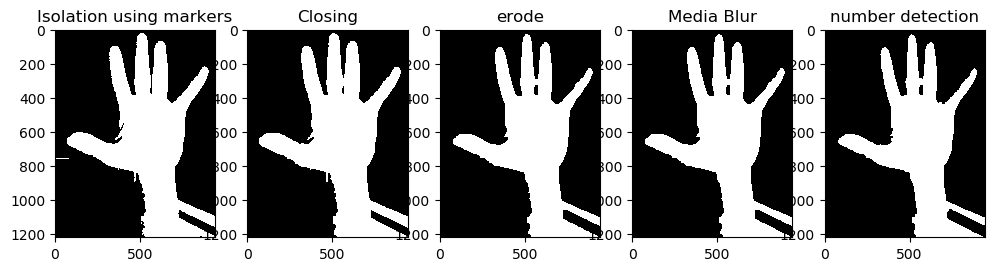

In [3]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
WaterShedStatic('.\croppedImage.jpg')



#### Eventhough the hand is only passed with little surrounding, the results are still not satisfying.
This techniques always fails when two fingers are close to each other or when the picture contains anything with colors similar to the hand. It's not robust and doesn't give accurate results unless under perfect conditions like uniform background.

## Hand detection using Deep Learning
This issue can be solved once and for all using deep learning to detect landmarks on the hands using the mediapipe library.
Once the landmarks are detected, we split them in left and right hand respectively.
Left hand landmarks are used to detect the requested channel number. This is done using a comparaison between the finger's tip and it's center. If the tip is above the center, then the finger is up. And we repeat this for everyfinger to check how many fingers are up.
Using the number of fingers up we can select a channel and change it's height. The requested height is given using the right hand, it corresponds to the index-thumb opening length, then mapped to a percentage.

From a technical perspective, the code is OOP structured, which will make it easily reusable and maintanable. We created a module containing a class that has all the fonctions. We first create a object from this class, then pass it the webcam's image to detect the landmarks and perform the analysis.

NB: Show your hands to the camera, if the tracked number and the levels bar are with the same hand, shake your hands and try again.

In [9]:
DPhandDetection()

KeyboardInterrupt: 

We can clearly see how it is perfectly working. When both hands are in front of the camera, all the landmarks are always detected. Two parameters could be changed in case it's not smooth, the detection confidence and tracking confidence. Detection confidence is the minimum confidence value (0-1) from the hand detection model for the detection to be considered successful.  It could be lowered in case we have considerable amount of false positive, like mistaking a part of the face for a hand.  The tracking confidence is the minimum confidence value (0-1) from the landmark-tracking model for the hand landmarks to be considered tracked successfully, or otherwise hand detection will be invoked automatically on the next input image. Setting it to a higher value can increase robustness of the solution, at the expense of a higher latency.

## Final comparaison

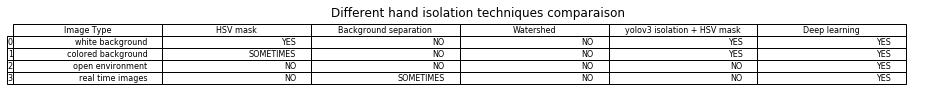

In [12]:
finalComparison()

## References
- Ref #1: https://iopscience.iop.org/article/10.1088/1757-899X/1045/1/012043/pdf
- Ref #2: https://docs.opencv.org/3.4/d0/d43/tutorial_js_table_of_contents_contours.html
- Ref #3: https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
- Ref #4: https://medium.com/analytics-vidhya/hand-detection-and-finger-counting-using-opencv-python-5b594704eb08
- Ref #5: https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html